In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy, LiederPolicy

from bandits import MetaBanditEnv
from evaluation import *

In [7]:
env = MetaBanditEnv(2, 30, 1e-3)
opt_pol, opt_val = optimal_policy(env, return_value=True)

optimal -> 0.6418914293448048 in 0.8461512530047912 sec


In [9]:

env.init

((1, 1), (1, 1))

In [8]:
from scipy.stats import beta
N = 100000
p = np.maximum(beta(1,1).rvs(N), beta(1,1).rvs(N)).mean()
p

0.66703638415629174

In [9]:
import skopt
import warnings
warnings.filterwarnings("ignore", 
                        message="The objective has been evaluated at this point before.")

COSTS = np.logspace(-3, -1, 5)
N_ARMS = [4, 8]
MAX_OBS = [20]
N_TRAIN = 1000
N_CALLS = 100
NORMALIZE = False

def filename(n_arm, max_obs, cost, normalize):
    c = round(float(cost), 5)
    n = int(normalize)
    return 'data/bandits_{}_{}_{}_{}'.format(n_arm, max_obs, c, n)
        
def write_bo_policy(n_arm, max_obs, cost, normalize=NORMALIZE):
    train_envs = [MetaBanditEnv(n_arm, max_obs, cost)] * N_TRAIN
    pol, result = bo_policy(train_envs, max_cost=max_obs,
                            normalize_voi=normalize, n_random_starts=10,
                            n_calls=N_CALLS, n_jobs=None, return_result=True,)
    fn = filename(n_arm, max_obs, cost, normalize)
    result.specs['args'].pop('func')  # can't pickle
    result.specs['info'] = {
        'cost': cost,
        'depth': depth,
        'normalize': normalize,
        'n_train': N_TRAIN,
        'n_calls': N_CALLS,
        'theta': pol.theta
    }
    skopt.dump(result, fn + '.pkl')
    np.save(fn + '.npy', pol.theta)
    return result

def read_bo_policy(n_arm, max_obs, cost, normalize=NORMALIZE):
    theta = np.load(filename(n_arm, max_obs, cost, normalize) + '.npy')
    return LiederPolicy(theta)

def read_bo_result(n_arm, max_obs, cost, normalize=NORMALIZE):
    return skopt.load(filename(n_arm, max_obs, cost, normalize) + '.pkl')

In [ ]:
write_bo_policy(N_ARMS[0], MAX_OBS[0], COSTS[0])

In [15]:
N_TEST = 1000

def empirical_best_yet(result, test_envs):
    best_v = -np.inf
    gp = result.models[-1]
    pred_val = -gp.predict(result.x_iters)
    for v, x in zip(pred_val, result.x_iters):
        if v > best_v:
            best_v = v
            theta = x2theta(x, NORMALIZE)
            util = evaluate(LiederPolicy(theta), test_envs).util
            mu, sd = util.mean(), util.std()
    
        yield mu, sd
        
def plot_learning(result, test_envs, opt_value=None):
    util, err = np.array(list(empirical_best_yet(result, test_envs))).T

    idx = np.arange(len(util))
    plt.errorbar(idx, util, err / np.sqrt(N_TEST))
    if opt_value is not None:
        plt.axhline(opt_value, c='r', ls='--')
    plt.xlabel('BO iteration ({} episodes)'.format(N_TRAIN))
    plt.ylabel('Empirical utility ({} episodes)'.format(N_TEST))
    plt.title('Learning curve')

prm = (3, 15, 0.001)
result = write_bo_policy(*prm)
policy = read_bo_policy(*prm)

test_envs = [MetaBanditEnv(*prm)] * N_TEST
opt_pol, opt_val = optimal_policy(test_envs[0], return_value=True)
blink = blinkered_policy(test_envs[0])
print(get_util(blink, test_envs))
print(get_util(policy, test_envs))

BO: [ 1.     1.     0.344  1.     1.   ] -> 0.437 in 272 sec
optimal -> 0.42275369968964016 in 0.2986692516133189 sec
blinkered -> 0.22668305550658496 in 0.0033505703322589397 sec
0.424082575758
0.407383529216


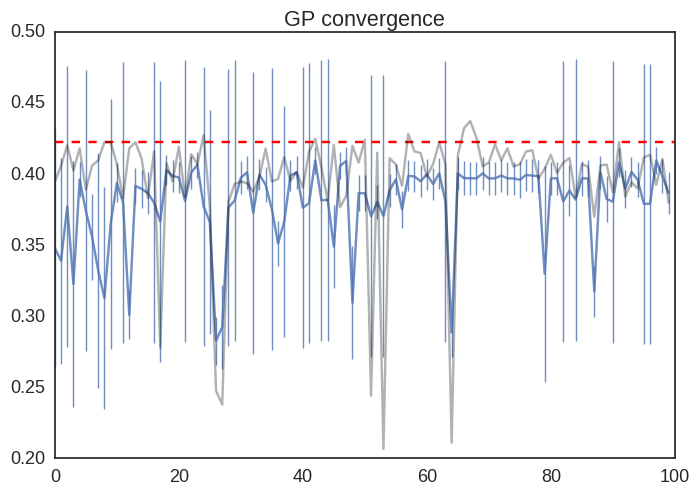

In [18]:
gp = result.models[-1]
mu, sd = gp.predict(result.x_iters, return_std=True)
pred_val = -mu
plt.errorbar(np.arange(len(pred_val)), pred_val, sd, elinewidth=1, alpha=.8)
plt.axhline(opt_val, c='r', ls='--')
plt.plot(- result.func_vals, c='k', alpha=.3)
plt.title('GP convergence')
theta, value = result.x_iters[pred_val.argmax()], pred_val.max()

In [57]:
theta = [Parallel(n_jobs=21)(delayed(write_bo_policy)(n_arm, max_obs, cost, norm)
                            for n_arm in N_ARMS
                            for max_obs in MAX_OBS
                            for cost in COSTS
                            for norm in (True, False))]

BO: [ 1.     0.219  0.     0.781  1.   ] -> 0.467 in 296 sec
BO: [ 1.     0.152  0.424  0.424  1.   ] -> 0.733 in 308 sec
BO: [ 1.     0.409  0.546  1.     1.   ] -> 0.794 in 318 sec
BO: [ 1.     0.206  0.418  0.375  1.   ] -> 0.77 in 337 sec
BO: [ 1.     0.368  0.745  0.802  1.   ] -> 0.791 in 339 sec
BO: [ 1.    0.34  1.    1.    1.  ] -> 0.555 in 344 sec
BO: [ 20.      0.234   0.239   0.528   1.   ] -> 0.803 in 349 sec
BO: [ 1.     0.287  0.     1.     1.   ] -> 0.759 in 352 sec
BO: [ 20.      1.      1.      0.799   1.   ] -> 0.723 in 354 sec
BO: [ 1.     0.234  0.383  0.383  1.   ] -> 0.743 in 359 sec
BO: [ 1.     0.214  0.131  0.655  1.   ] -> 0.771 in 370 sec
BO: [ 20.   0.   1.   1.   1.] -> 0.241 in 373 sec
BO: [ 19.31    0.383   0.792   0.529   1.   ] -> 0.008 in 381 sec
BO: [ 20.      0.      0.788   0.      1.   ] -> 0.766 in 382 sec
BO: [ 20.      0.261   1.      0.866   1.   ] -> 0.792 in 383 sec
BO: [ 1.     0.402  0.598  0.     1.   ] -> 0.718 in 387 sec
BO: [ 13.98    

/home/fredcallaway/miniconda3/lib/python3.5/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BO: [ 1.  0.  1.  1.  1.] -> 0.7 in 27 sec
optimal -> 0.5656420666241192 in 0.038956983014941216 sec
CPU times: user 2min, sys: 14min 34s, total: 16min 35s
Wall time: 27.5 s


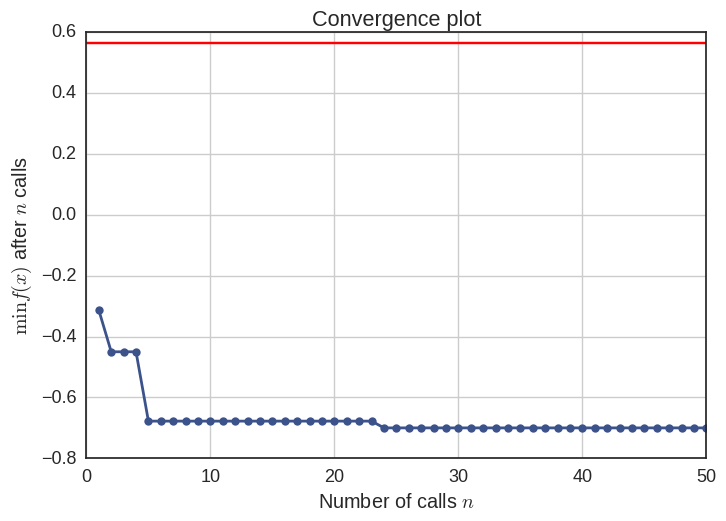

In [49]:
%%time
env = MetaBanditEnv(5, 25, 0.01)
train_envs = [env] * 200
pol, result = bo_policy(train_envs, max_cost=100, normalize_voi=False,
                        n_jobs=1, n_calls=50, verbose=0, return_result=True)

from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)
opt, v = optimal_policy(env, return_value=True)
plt.axhline(v, c='r')

In [7]:
optimal_policy(MetaBanditEnv(4, 15, .1))

optimal -> 0.0 in 0.9686033483594656 sec


In [61]:
def run_params(n_arm, max_obs, cost):
    env = MetaBanditEnv(n_arm, max_obs, cost)
    train_envs = [env] * 500
    term_action = train_envs[0].term_action
    policies = {
        'BO': read_bo_policy(n_arm, max_obs, cost, False),
#         'BO_unnorm': read_bo_policy(n_arm, max_obs, cost, False),
        # 'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
        'blinkered': blinkered_policy(env),
        # 'optimal': optimal_policy(env),
        # 'full-observation': LiederPolicy([-100, 0.5, 0.5, 0, 1]),
        # 'none': FixedPlanPolicy([term_action]),
    }
    test_envs = [env] * 1000
    def test():
        for name, policy in policies.items():
            df = evaluate(policy, envs=test_envs)
            df['agent'] = name
            df['n_arm'] = n_arm
            df['max_obs'] = max_obs
            df['cost'] = cost
            yield df
    return pd.concat(test())
    
params = list(it.product(N_ARMS, MAX_OBS, COSTS))
data = Parallel(n_jobs=len(params))(delayed(run_params)(*prm) for prm in params)
df = pd.concat(data)

blinkered -> 0.23457501586460772 in 0.02382762124761939 sec
blinkered -> 0.21269728495949977 in 0.020461791194975376 sec
blinkered -> 0.06666666666666662 in 0.02001724625006318 sec
blinkered -> 0.22814861557431215 in 0.03545670211315155 sec
blinkered -> 0.2369038098966737 in 0.036579759791493416 sec
blinkered -> 0.21269728495949977 in 0.03567158430814743 sec
blinkered -> 0.1832061272061272 in 0.035393652971833944 sec
blinkered -> 0.13504389006498285 in 0.03538782196119428 sec
blinkered -> 0.06666666666666662 in 0.035070333164185286 sec
blinkered -> 0.23457501586460772 in 0.036258426029235125 sec
blinkered -> 0.1832061272061272 in 0.033622580114752054 sec
blinkered -> 0.22814861557431215 in 0.03742798510938883 sec
blinkered -> 0.2369038098966737 in 0.03965167421847582 sec
blinkered -> 0.13504389006498285 in 0.03585841413587332 sec
blinkered -> 0.23457501586460772 in 0.03463079174980521 sec
blinkered -> 0.22814861557431215 in 0.034514171071350574 sec
blinkered -> 0.2369038098966737 in 0.

In [77]:
for i, (k, gd) in enumerate(g):
    print(k)

8


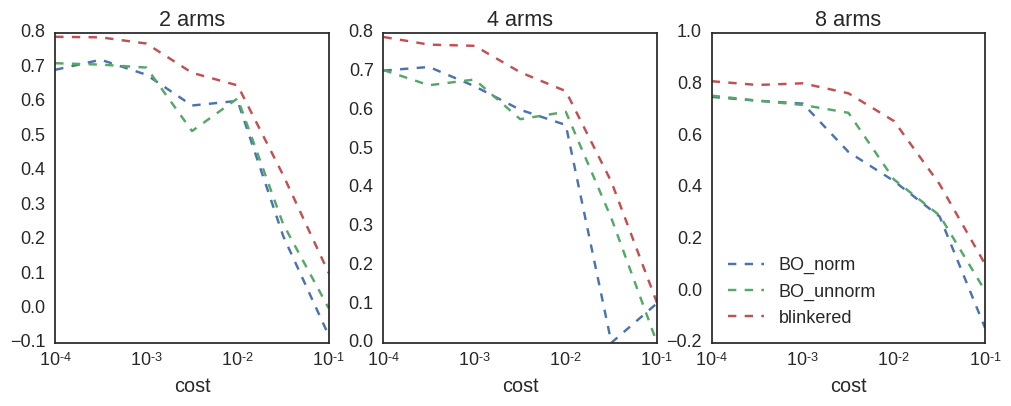

In [90]:
size=4
key = 'n_arm'
g = df.groupby(key)
fig, axes = plt.subplots(figsize=(size * len(g), size), ncols=len(g),)
for (k, gd), ax in zip(g, axes):
    ax.set_title('{} arms'.format(k))
    gd.groupby('cost agent'.split()).util.mean().unstack().plot(logx=True, ls='--', ax=ax, legend=False)
plt.legend(loc='lower left')

In [ ]:
# df = pd.DataFrame(randint(0,10,(200,6)),columns=list('abcdef'))
g = df.groupby('n_arm')
fig, axs = plt.subplots(figsize=(9,4),  ncols=
                        
                    ,)
#                         gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

targets = zip(g.groups.keys(), axs.flatten())
for i, (key, ax) in enumerate(targets):
#     ax.plot(g.get_group(key))
    
    ax.set_title('n_arm=%d'%key)
ax.legend()
plt.show()

(0, 1)

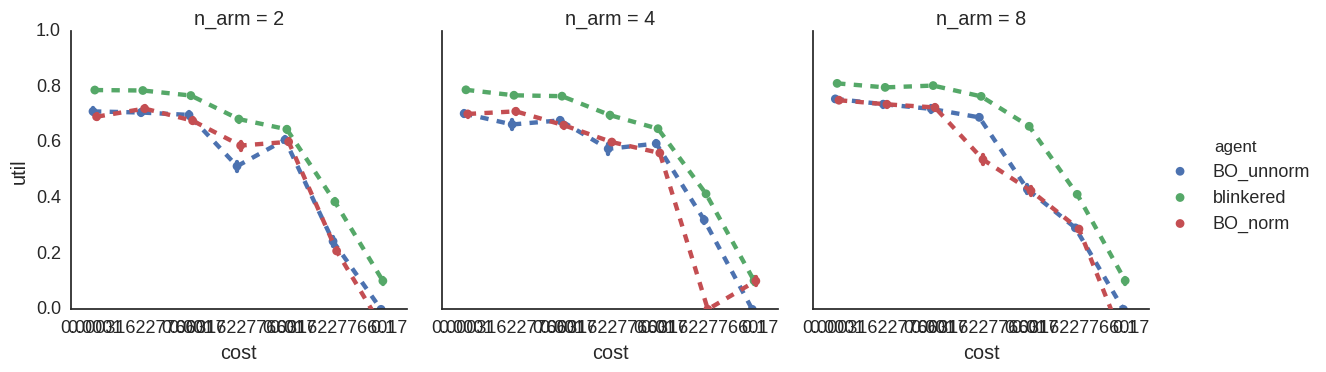

In [64]:

# df.groupby('cost agent'.split()).rate.mean().unstack().plot(logx=True, ls='--')
# plt.ylim(-.5,1)

In [86]:
empirical = df.query('agent == "BO"').util
# print('BO = {:.1f}'.format(-result.fun))
print('empirical ~ $N({:.1f}, {:.1f}^2)$'.format(empirical.mean(), empirical.std()))

empirical ~ $N(14.9, 14.9^2)$


In [26]:
empirical = df.query('agent == "BO"').util
print('BO = {:.1f}'.format(-result.fun))
print('empirical ~ $N({:.1f}, {:.1f}^2)$'.format(empirical.mean(), empirical.std()))

BO = 14.1
empirical ~ $N(12.0, 11.9^2)$


12.425000000000001

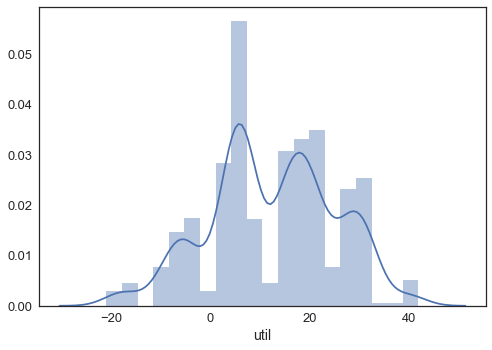

In [62]:
sns.distplot(df.query('agent == "BO"').util)
df.query('agent == "BO"').util.mean()

In [16]:
env = MetaBanditEnv(5, 20, 0.01)
policy = LiederPolicy([1,1,1,1,1])
agent = Agent()
agent.register(env)
agent.register(policy)

def test():
    tr = agent.run_episode()
    print(len(tr['actions']))

%prun test()

21
 

In [4]:
# pol = LiederPolicy([1,0,0,1,1])
pol = LiederPolicy([5.939, 0.715, 0.603, 0.545, 1.])
env = MetaBanditEnv(25, 30, 0.001)
envs = [env] * 1000
def test():
    print(get_util(pol, envs))

%prun test()

0.791763336205
 